In [1]:
import xarray as xr
import numpy as np
from collections import defaultdict

# Messing with times
from datetime import datetime, time, timedelta

# Downloading TREx files
import os
import requests
from urllib.parse import urljoin
from bs4 import BeautifulSoup

# For reading TREx files
import imageio
from PIL import Image

# Moon/Sun Filtering
import ephem  
from math import radians as rad,degrees as deg  

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import pandas as pd

# Folder where the data is stored on my computer
folder = "feb_data/0_data/trex_spectrograph_data/"

In [2]:
# Load elevation angle and wavelength data
elevation_angle = np.load('elevation_angle.npy')
wavelength = np.load('wavelengths.npy')

In [5]:
# Read each file by day, store each data into daily_data dictionary

def read_pgm_files_by_day(folder):
    daily_data = {}
    for day_folder in sorted(os.listdir(folder)):
        day_path = os.path.join(folder, day_folder)
        if os.path.isdir(day_path):
            images = []
            timestamps = []
            for filename in sorted(os.listdir(day_path)):
                if filename.endswith(".pgm"):
                    timestamp_str = filename.split('_')[0] + filename.split('_')[1]  # Extracting 'YYYYMMDD_HHMM' part
                    timestamp = datetime.strptime(timestamp_str, "%Y%m%d%H%M")
                    timestamps.append(timestamp)

                    # Read image
                    filepath = os.path.join(day_path, filename)
                    image = imageio.v2.imread(filepath)
                    images.append(image)
            daily_data[day_folder] = (images, timestamps)
    return daily_data

In [7]:
# Function to retrieve the data cube for a given day
def get_data_cube_for_day(folder, day_str, daily_data):
    day_data = daily_data.get(day_str, ([], []))
    images, timestamps = day_data
    data_cube = np.array(images)
    time_array = np.array(timestamps)
    return data_cube, time_array

In [9]:
## MOON/SUN FILTERING ##

RL = ephem.Observer()  
RL.name='Rabbit Lake'  
RL.lat=str(53.1380) # lat/long in decimal degrees  
RL.long=str(-107.7674) 
Moon_obj = ephem.Moon()
Sun_obj = ephem.Sun() 

def moon_filter(data_cube, time_array):

    # Convert data_cube to float type to handle NaN values
    data_cube = data_cube.astype(np.float32)
    
    for time_index in range(data_cube.shape[0]):
        RL.date = time_array[time_index]
        Moon_obj.compute(RL)
        Sun_obj.compute(RL)
        Moon_ele = deg(Moon_obj.alt)  # [deg]
        Sun_ele = deg(Sun_obj.alt)  # [deg]

        if Moon_ele >= -15 or Sun_ele >= -15:
            data_cube[time_index, :, :] = np.nan

    return data_cube

In [11]:
# Find the max luminosity at each elevation angle within specified wavelength range

def find_max_luminosity_wavelengths(averaged_data, wavelength, wavelength_range):
    min_wavelength, max_wavelength = wavelength_range
    indices = (wavelength >= min_wavelength) & (wavelength <= max_wavelength)
    max_luminosity_wavelengths = np.zeros(averaged_data.shape[1])
    for i in range(averaged_data.shape[1]):
        max_index = np.argmax(averaged_data[indices, i])
        max_luminosity_wavelengths[i] = wavelength[indices][max_index]
    return max_luminosity_wavelengths

In [13]:
# Get data for specified day

def get_keograms_for_day(folder, choose_day, daily_data, elevation_angle, wavelength):
    # Retrieve data cube and timestamps for the day
    data_cube, time_array = get_data_cube_for_day(folder, choose_day, daily_data)
    
    # Apply the time filtering
    data_cube_t_filtered = moon_filter(data_cube, time_array)
    data_cube_t_average = np.nanmedian(data_cube_t_filtered, axis=0)  # Use nanmedian to ignore NaNs

    green_line_keogram = correct_green_data(data_cube_t_filtered, data_cube_t_average, elevation_angle, wavelength)
    blue_line_keogram = correct_blue_data(data_cube_t_filtered, data_cube_t_average, elevation_angle, wavelength)

    return green_line_keogram, blue_line_keogram, time_array

In [15]:
def plot_green_keogram(green_line_keogram, time_array, elevation_angle):
    time_grid, elevation_angle_grid = np.meshgrid(time_array, elevation_angle)
    plt.figure(figsize=(20, 6))
    plt.pcolormesh(time_grid, elevation_angle_grid, green_line_keogram.T, vmin=0, vmax=35000, cmap='Greens_r', shading='gouraud')
    plt.ylim((0, 180))
    plt.colorbar(label='Luminosity (arb. units)')
    plt.xlabel('Time (UTC)')
    plt.ylabel('Elevation Angle (Degrees)')
    plt.title('Green Keogram')
    plt.gca().invert_yaxis()
    plt.show()

In [17]:
def plot_blue_keogram(blue_line_keogram, time_array, elevation_angle):
    time_grid, elevation_angle_grid = np.meshgrid(time_array, elevation_angle)
    plt.figure(figsize=(20, 6))
    plt.pcolormesh(time_grid, elevation_angle_grid, blue_line_keogram.T, vmin=0, vmax=1200, cmap='Blues_r', shading='gouraud')
    plt.ylim((0, 180))
    plt.colorbar(label='Luminosity (arb. units)')
    plt.xlabel('Time (UTC)')
    plt.ylabel('Elevation Angle (Degrees)')
    plt.title('Blue Keogram')
    plt.gca().invert_yaxis()
    plt.show()

In [19]:
def plot_ratio_keogram(green_line_keogram, blue_line_keogram, time_array, elevation_angle, persistent_indices=None):
    ratio_keogram = green_line_keogram / blue_line_keogram
    time_grid, elevation_angle_grid = np.meshgrid(time_array, elevation_angle)
    plt.figure(figsize=(20, 6))
    pcolormesh_plot = plt.pcolormesh(time_grid, elevation_angle_grid, ratio_keogram.T, vmin=0, vmax=60, cmap='PRGn', shading='gouraud')
    plt.ylim((0, 180))
    plt.colorbar(pcolormesh_plot, label='Green/Blue Ratio')
    plt.xlabel('Time (UTC)')
    plt.ylabel('Elevation Angle (Degrees)')
    plt.title('Ratio Keogram')
    plt.gca().invert_yaxis()

In [21]:
def plot_ratio_keogram_overlay(green_line_keogram, blue_line_keogram, time_array, elevation_angle, persistent_indices):
    ratio_keogram = green_line_keogram / blue_line_keogram

    time_grid, elevation_angle_grid = np.meshgrid(time_array, elevation_angle)

    plt.figure(figsize=(20, 6))
    pcolormesh_plot = plt.pcolormesh(time_grid, elevation_angle_grid, ratio_keogram.T, vmin=0, vmax=60, cmap='PRGn', shading='gouraud')

    if persistent_indices:
        for t_idx, el_idx in persistent_indices:
            plt.scatter(time_array[t_idx], elevation_angle[el_idx], color='red')

    plt.ylim((0, 180))
    plt.colorbar(pcolormesh_plot, label='Green/Blue Ratio')
    plt.xlabel('Time (UTC)')
    plt.ylabel('Elevation Angle (Degrees)')
    plt.title('Ratio Keogram (with notable ratios)')
    plt.gca().invert_yaxis()

In [23]:
### AUTOMATION ###

In [25]:
# Initialize data for the entire month
daily_data = read_pgm_files_by_day(folder)

In [29]:
## GREEN CORRECTION ##

def correct_green_data(data_cube_t_filtered, data_cube_t_average, elevation_angle, wavelength):
    green_line_distortion_range = (540, 575)
    max_luminosity_wavelengths_green = find_max_luminosity_wavelengths(data_cube_t_average, wavelength, green_line_distortion_range)

    green_line_min = 540.0
    green_line_peak_start = 555.2
    green_line_peak_end = 560.7
    green_line_max = 575.0

    green_line_peak_wavelength = 557.7  # Midline of the green peak

    # Initialize arrays for corrected data cube and green line keogram
    green_line_keogram = np.empty((data_cube_t_filtered.shape[0], len(elevation_angle)))
    #green_baseline_keogram = np.empty((data_cube_t_filtered.shape[0], len(elevation_angle)))
    #green_distortion_corrections = np.empty(len(elevation_angle))  # Store distortion corrections

    window_size = 30

    # Loop through elevation angles
    for el in range(len(elevation_angle)):
        # Calculate the distortion for the current elevation angle
        distortion_from_557 = max_luminosity_wavelengths_green[el] - green_line_peak_wavelength

        green_before_ind = (wavelength >= green_line_min + distortion_from_557) & (wavelength <= green_line_peak_start + distortion_from_557)
        green_after_ind = (wavelength >= green_line_peak_end + distortion_from_557) & (wavelength <= green_line_max + distortion_from_557)
        green_indices = (wavelength >= green_line_peak_start + distortion_from_557) & (wavelength <= green_line_peak_end + distortion_from_557)

        print(f'Elevation Angle Index: {el}')

        for t_ind in range(window_size // 2, data_cube_t_filtered.shape[0] - window_size // 2):
            if np.isnan(data_cube_t_filtered[t_ind, :, el]).any():
                green_line_keogram[t_ind, el] = np.nan
                #green_baseline_keogram[t_ind, el] = np.nan
            else:
                window_start = t_ind - window_size // 2
                window_end = t_ind + window_size // 2

                # Extract and average the data for the current 30-minute window
                averaged_window_data = np.nanmedian(data_cube_t_filtered[window_start:window_end + 1, :, el], axis=0)

                # Calculate baseline as the median of collected values within the window
                green_baseline_before = np.nanmedian(averaged_window_data[green_before_ind])
                green_baseline_after = np.nanmedian(averaged_window_data[green_after_ind])
                green_baseline = (green_baseline_before + green_baseline_after) / 2

                #green_baseline_keogram[t_ind, el] = green_baseline

                # Apply distortion correction
                green_line_keogram[t_ind, el] = np.sum(data_cube_t_filtered[t_ind, green_indices, el] - green_baseline)

    return green_line_keogram

In [31]:
## BLUE CORRECTION ##

def correct_blue_data(data_cube_t_filtered, data_cube_t_average, elevation_angle, wavelength):
    blue_line_distortion_range = (450, 480)
    max_luminosity_wavelengths_blue = find_max_luminosity_wavelengths(data_cube_t_average, wavelength, blue_line_distortion_range)

    blue_line_min = 450.0
    blue_line_peak_start = 468.0
    blue_line_peak_end = 474.0
    blue_line_max = 480.0

    blue_line_peak_wavelength = 470.9  # Midline of the blue peak

    # Initialize arrays for corrected data cube and blue line keogram
    blue_line_keogram = np.empty((data_cube_t_filtered.shape[0], len(elevation_angle)))
    #blue_baseline_keogram = np.empty((data_cube_t_filtered.shape[0], len(elevation_angle)))
    #blue_distortion_corrections = np.empty(len(elevation_angle))  # Store distortion corrections

    window_size = 30

    # Loop through elevation angles
    for el in range(len(elevation_angle)):
        # Calculate the distortion for the current elevation angle
        distortion_from_470 = max_luminosity_wavelengths_blue[el] - blue_line_peak_wavelength
        #blue_distortion_corrections[el] = distortion_from_470  # Store the distortion correction

        blue_before_ind = (wavelength >= blue_line_min + distortion_from_470) & (wavelength <= blue_line_peak_start + distortion_from_470)
        blue_after_ind = (wavelength >= blue_line_peak_end + distortion_from_470) & (wavelength <= blue_line_max + distortion_from_470)
        blue_indices = (wavelength >= blue_line_peak_start + distortion_from_470) & (wavelength <= blue_line_peak_end + distortion_from_470)

        print(f'Elevation Angle Index: {el}')

        for t_ind in range(window_size // 2, data_cube_t_filtered.shape[0] - window_size // 2):
            if np.isnan(data_cube_t_filtered[t_ind, :, el]).any():
                blue_line_keogram[t_ind, el] = np.nan
                #blue_baseline_keogram[t_ind, el] = np.nan
            else:
                window_start = t_ind - window_size // 2
                window_end = t_ind + window_size // 2

                # Extract and average the data for the current 30-minute window
                averaged_window_data = np.nanmedian(data_cube_t_filtered[window_start:window_end + 1, :, el], axis=0)

                # Calculate baseline as the median of collected values within the window
                blue_baseline_before = np.nanmedian(averaged_window_data[blue_before_ind])
                blue_baseline_after = np.nanmedian(averaged_window_data[blue_after_ind])
                blue_baseline = (blue_baseline_before + blue_baseline_after) / 2

                #blue_baseline_keogram[t_ind, el] = blue_baseline

                # Apply distortion correction
                blue_line_keogram[t_ind, el] = np.sum(data_cube_t_filtered[t_ind, blue_indices, el] - blue_baseline)

    return blue_line_keogram

In [33]:
## MONTH-LONG FUNCTIONS ##

In [35]:
# function for entire month of data

def calculate_ratios_above_threshold(folder, daily_data, elevation_angle, wavelength, threshold=26, min_green_count=15000):
    ratios_above_green_threshold = defaultdict(list)
    daily_filtered_time_arrays = {}

    for day_str in sorted(daily_data.keys()):
        print(day_str)
        # Get green and blue keograms for the day + the filtered time array
        green_line_keogram, blue_line_keogram, filtered_time_array = get_keograms_for_day(folder, day_str, daily_data, elevation_angle, wavelength)
        daily_filtered_time_arrays[day_str] = filtered_time_array

        ratio = green_line_keogram / blue_line_keogram

        # Filter green counts above 15000 and ratios > 26
        valid_green_indices = (green_line_keogram >= min_green_count) & (ratio > threshold)

        # Store calculated ratios + their timestamps
        for t_idx in range(ratio.shape[0]):
            for e_idx in range(ratio.shape[1]):
                if valid_green_indices[t_idx, e_idx]:
                    ratios_above_green_threshold[day_str].append((t_idx, e_idx, ratio[t_idx, e_idx]))

    # Combine all ratios into a single list for calculating the 80th percentile threshold
    all_ratios = np.array([item[2] for sublist in ratios_above_green_threshold.values() for item in sublist])
    
    return ratios_above_green_threshold, all_ratios, daily_filtered_time_arrays


In [37]:
ratios_above_green_threshold, all_ratios, daily_time_arrays = calculate_ratios_above_threshold(folder, daily_data, elevation_angle, wavelength, threshold=26, min_green_count=15000)

20230201


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


Elevation Angle Index: 0
Elevation Angle Index: 1
Elevation Angle Index: 2
Elevation Angle Index: 3
Elevation Angle Index: 4
Elevation Angle Index: 5
Elevation Angle Index: 6
Elevation Angle Index: 7
Elevation Angle Index: 8
Elevation Angle Index: 9
Elevation Angle Index: 10
Elevation Angle Index: 11
Elevation Angle Index: 12
Elevation Angle Index: 13
Elevation Angle Index: 14
Elevation Angle Index: 15
Elevation Angle Index: 16
Elevation Angle Index: 17
Elevation Angle Index: 18
Elevation Angle Index: 19
Elevation Angle Index: 20
Elevation Angle Index: 21
Elevation Angle Index: 22
Elevation Angle Index: 23
Elevation Angle Index: 24
Elevation Angle Index: 25
Elevation Angle Index: 26
Elevation Angle Index: 27
Elevation Angle Index: 28
Elevation Angle Index: 29
Elevation Angle Index: 30
Elevation Angle Index: 31
Elevation Angle Index: 32
Elevation Angle Index: 33
Elevation Angle Index: 34
Elevation Angle Index: 35
Elevation Angle Index: 36
Elevation Angle Index: 37
Elevation Angle Index:

/var/folders/k3/vs84nfp10mj73vn5vcy8dsg00000gn/T/ipykernel_32642/3932413479.py:13: RuntimeWarning: invalid value encountered in divide
  ratio = green_line_keogram / blue_line_keogram


Elevation Angle Index: 0
Elevation Angle Index: 1
Elevation Angle Index: 2
Elevation Angle Index: 3
Elevation Angle Index: 4
Elevation Angle Index: 5
Elevation Angle Index: 6
Elevation Angle Index: 7
Elevation Angle Index: 8
Elevation Angle Index: 9
Elevation Angle Index: 10
Elevation Angle Index: 11
Elevation Angle Index: 12
Elevation Angle Index: 13
Elevation Angle Index: 14
Elevation Angle Index: 15
Elevation Angle Index: 16
Elevation Angle Index: 17
Elevation Angle Index: 18
Elevation Angle Index: 19
Elevation Angle Index: 20
Elevation Angle Index: 21
Elevation Angle Index: 22
Elevation Angle Index: 23
Elevation Angle Index: 24
Elevation Angle Index: 25
Elevation Angle Index: 26
Elevation Angle Index: 27
Elevation Angle Index: 28
Elevation Angle Index: 29
Elevation Angle Index: 30
Elevation Angle Index: 31
Elevation Angle Index: 32
Elevation Angle Index: 33
Elevation Angle Index: 34
Elevation Angle Index: 35
Elevation Angle Index: 36
Elevation Angle Index: 37
Elevation Angle Index:

/var/folders/k3/vs84nfp10mj73vn5vcy8dsg00000gn/T/ipykernel_32642/3932413479.py:13: RuntimeWarning: divide by zero encountered in divide
  ratio = green_line_keogram / blue_line_keogram


20230211
Elevation Angle Index: 0
Elevation Angle Index: 1
Elevation Angle Index: 2
Elevation Angle Index: 3
Elevation Angle Index: 4
Elevation Angle Index: 5
Elevation Angle Index: 6
Elevation Angle Index: 7
Elevation Angle Index: 8
Elevation Angle Index: 9
Elevation Angle Index: 10
Elevation Angle Index: 11
Elevation Angle Index: 12
Elevation Angle Index: 13
Elevation Angle Index: 14
Elevation Angle Index: 15
Elevation Angle Index: 16
Elevation Angle Index: 17
Elevation Angle Index: 18
Elevation Angle Index: 19
Elevation Angle Index: 20
Elevation Angle Index: 21
Elevation Angle Index: 22
Elevation Angle Index: 23
Elevation Angle Index: 24
Elevation Angle Index: 25
Elevation Angle Index: 26
Elevation Angle Index: 27
Elevation Angle Index: 28
Elevation Angle Index: 29
Elevation Angle Index: 30
Elevation Angle Index: 31
Elevation Angle Index: 32
Elevation Angle Index: 33
Elevation Angle Index: 34
Elevation Angle Index: 35
Elevation Angle Index: 36
Elevation Angle Index: 37
Elevation Ang

In [41]:
# Define a function to calculate the 80th percentile threshold
def calculate_80th_percentile(valid_ratios):
    if len(valid_ratios) == 0:
        print("No valid ratios found.")
        return None
    # Calculate the 80th percentile threshold
    threshold_80th_percentile = np.percentile(valid_ratios, 80)
    print(f"80th percentile threshold: {threshold_80th_percentile}")
    return threshold_80th_percentile

In [43]:
# Step to gather all ratios, ensuring blue is not zero
print(f"All ratios count before: {len(all_ratios)}")
all_ratios = np.array([item[2] for sublist in ratios_above_green_threshold.values() for item in sublist if item[2] < 1e6])  # Assuming a very large ratio is invalid

# Debugging: Print the all_ratios array details
print(f"All ratios count after: {len(all_ratios)}")
print(f"All ratios: {all_ratios}")
print(f"Data type of all_ratios: {all_ratios.dtype}")
print(f"Min value in all_ratios: {np.min(all_ratios)}")
print(f"Max value in all_ratios: {np.max(all_ratios)}")

# Filter out invalid values
valid_ratios = all_ratios[np.isfinite(all_ratios)]
print(f"Valid ratios count: {len(valid_ratios)}")
print(f"Valid ratios: {valid_ratios}")

All ratios count before: 14173
All ratios count after: 14069
All ratios: [40.82668411 38.25327511 38.70880361 ... 42.39269699 31.99574015
 34.98079096]
Data type of all_ratios: float64
Min value in all_ratios: 26.0207336523126
Max value in all_ratios: 66942.0
Valid ratios count: 14069
Valid ratios: [40.82668411 38.25327511 38.70880361 ... 42.39269699 31.99574015
 34.98079096]


In [45]:
# Calculate the 80th percentile threshold using valid ratios
threshold_80th_percentile = calculate_80th_percentile(valid_ratios)

80th percentile threshold: 47.762923982702034


In [47]:
def check_time_persistence(ratios_above_green_threshold, threshold, min_duration=5):
    persistent_high_ratio_indices = defaultdict(list)
    streak_details = defaultdict(list)

    for day_str, ratios_for_day in ratios_above_green_threshold.items():
        if len(ratios_for_day) == 0:
            continue
        
        # Group by time index to check persistence
        time_groups = defaultdict(list)
        for t_idx, e_idx, ratio_value in ratios_for_day:
            time_groups[t_idx].append((e_idx, ratio_value))

        sorted_times = sorted(time_groups.keys())
        current_streak = []

        for i in range(len(sorted_times)):
            if i == 0 or sorted_times[i] == sorted_times[i - 1] + 1:
                current_streak.append(sorted_times[i])
            else:
                if len(current_streak) >= min_duration:
                    # Record the start and length of the streak
                    streak_start = current_streak[0]
                    streak_length = len(current_streak)
                    
                    # Store each time index + elev index in persistent_high_ratio_indices
                    for t_idx in current_streak:
                        for e_idx, ratio_value in time_groups[t_idx]:
                            if ratio_value >= threshold:
                                persistent_high_ratio_indices[day_str].append((t_idx, e_idx))
                    
                    # Store streak details for printing
                    streak_details[day_str].append((streak_start, streak_length))
                    
                current_streak = [sorted_times[i]]

        # Check the last streak
        if len(current_streak) >= min_duration:
            streak_start = current_streak[0]
            streak_length = len(current_streak)
            
            # Store each time index and elevation index in persistent_high_ratio_indices
            for t_idx in current_streak:
                for e_idx, ratio_value in time_groups[t_idx]:
                    if ratio_value >= threshold:
                        persistent_high_ratio_indices[day_str].append((t_idx, e_idx))
            
            # Store streak details for printing
            streak_details[day_str].append((streak_start, streak_length))

    return persistent_high_ratio_indices, streak_details

In [49]:
persistent_high_ratio_indices, streak_details = check_time_persistence(ratios_above_green_threshold, threshold_80th_percentile, min_duration=5)

In [51]:
def print_high_ratio_times(streak_details, daily_filtered_time_arrays, threshold_80th_percentile):
    '''
    Note: There may be multiple persistent high ratio occurrences within the same minute, but at various elevation angles.
    This loop will only print each timestamp where there are persistent high ratio occurrences ONCE, despite the fact that there may
    be multiple occurrences at different elevations.
    '''
    
    # Iterate through each day in streak_details
    for day_str in sorted(streak_details.keys()):
        streaks = streak_details[day_str]
        
        if streaks:
            seen_timestamps = set()  # To track already printed timestamps
            unique_streaks = sorted(set(streaks))  # Remove duplicates and sort
            count_unique_timestamps = len(unique_streaks)  # Count unique timestamps
            
            # Print day string with unique timestamp count
            print(f"Day {day_str}: {count_unique_timestamps} occurrences with green/blue ratio > {threshold_80th_percentile}")
            
            # Get the filtered time array for the current day
            filtered_time_array = daily_filtered_time_arrays[day_str]
            
            # Print each unique streak start time and duration in datetime format
            for start_time_index, duration in unique_streaks:
                if start_time_index not in seen_timestamps:
                    dt_timestamp = filtered_time_array[start_time_index]  # Convert time index to datetime
                    print(f"Start: {dt_timestamp.strftime('%H:%M:%S')}, Duration: {duration} minutes")
                    seen_timestamps.add(start_time_index)  # Mark this timestamp as seen
        else:
            print(f"No persistent timestamps found for Day {day_str}.")

In [53]:
print_high_ratio_times(streak_details, daily_time_arrays, threshold_80th_percentile)

Day 20230210: 1 occurrences with green/blue ratio > 47.762923982702034
Start: 02:31:00, Duration: 8 minutes
Day 20230214: 2 occurrences with green/blue ratio > 47.762923982702034
Start: 07:21:00, Duration: 5 minutes
Start: 07:58:00, Duration: 12 minutes
Day 20230215: 6 occurrences with green/blue ratio > 47.762923982702034
Start: 03:21:00, Duration: 5 minutes
Start: 06:10:00, Duration: 9 minutes
Start: 06:21:00, Duration: 16 minutes
Start: 08:23:00, Duration: 17 minutes
Start: 08:47:00, Duration: 10 minutes
Start: 09:04:00, Duration: 5 minutes
Day 20230216: 5 occurrences with green/blue ratio > 47.762923982702034
Start: 06:10:00, Duration: 52 minutes
Start: 07:04:00, Duration: 20 minutes
Start: 07:25:00, Duration: 5 minutes
Start: 09:19:00, Duration: 15 minutes
Start: 09:35:00, Duration: 7 minutes
Day 20230217: 1 occurrences with green/blue ratio > 47.762923982702034
Start: 04:37:00, Duration: 7 minutes
Day 20230218: 1 occurrences with green/blue ratio > 47.762923982702034
Start: 04:55

In [55]:
### PLOTTING ###

In [57]:
# Plot keograms for specific date
choose_day = '20230221'
#start_time= datetime(2023,2,4,2)
#end_time = datetime(2023,2,21,4)

In [59]:
# get keogram for chosen day
green_line_keogram, blue_line_keogram, filtered_time_array = get_keograms_for_day(folder, choose_day, daily_data, elevation_angle, wavelength)

Elevation Angle Index: 0
Elevation Angle Index: 1
Elevation Angle Index: 2
Elevation Angle Index: 3
Elevation Angle Index: 4
Elevation Angle Index: 5
Elevation Angle Index: 6
Elevation Angle Index: 7
Elevation Angle Index: 8
Elevation Angle Index: 9
Elevation Angle Index: 10
Elevation Angle Index: 11
Elevation Angle Index: 12
Elevation Angle Index: 13
Elevation Angle Index: 14
Elevation Angle Index: 15
Elevation Angle Index: 16
Elevation Angle Index: 17
Elevation Angle Index: 18
Elevation Angle Index: 19
Elevation Angle Index: 20
Elevation Angle Index: 21
Elevation Angle Index: 22
Elevation Angle Index: 23
Elevation Angle Index: 24
Elevation Angle Index: 25
Elevation Angle Index: 26
Elevation Angle Index: 27
Elevation Angle Index: 28
Elevation Angle Index: 29
Elevation Angle Index: 30
Elevation Angle Index: 31
Elevation Angle Index: 32
Elevation Angle Index: 33
Elevation Angle Index: 34
Elevation Angle Index: 35
Elevation Angle Index: 36
Elevation Angle Index: 37
Elevation Angle Index:

In [61]:
# Create grids for keogram plotting
time_grid, elevation_angle_grid = np.meshgrid(filtered_time_array, elevation_angle)

In [63]:
# Parse the choose_day string to get the date and format it
date_obj = datetime.strptime(choose_day, '%Y%m%d')
formatted_date = date_obj.strftime('%B %d, %Y')

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120'),
  Text(0, 140.0, '140'),
  Text(0, 160.0, '160'),
  Text(0, 180.0, '180')])

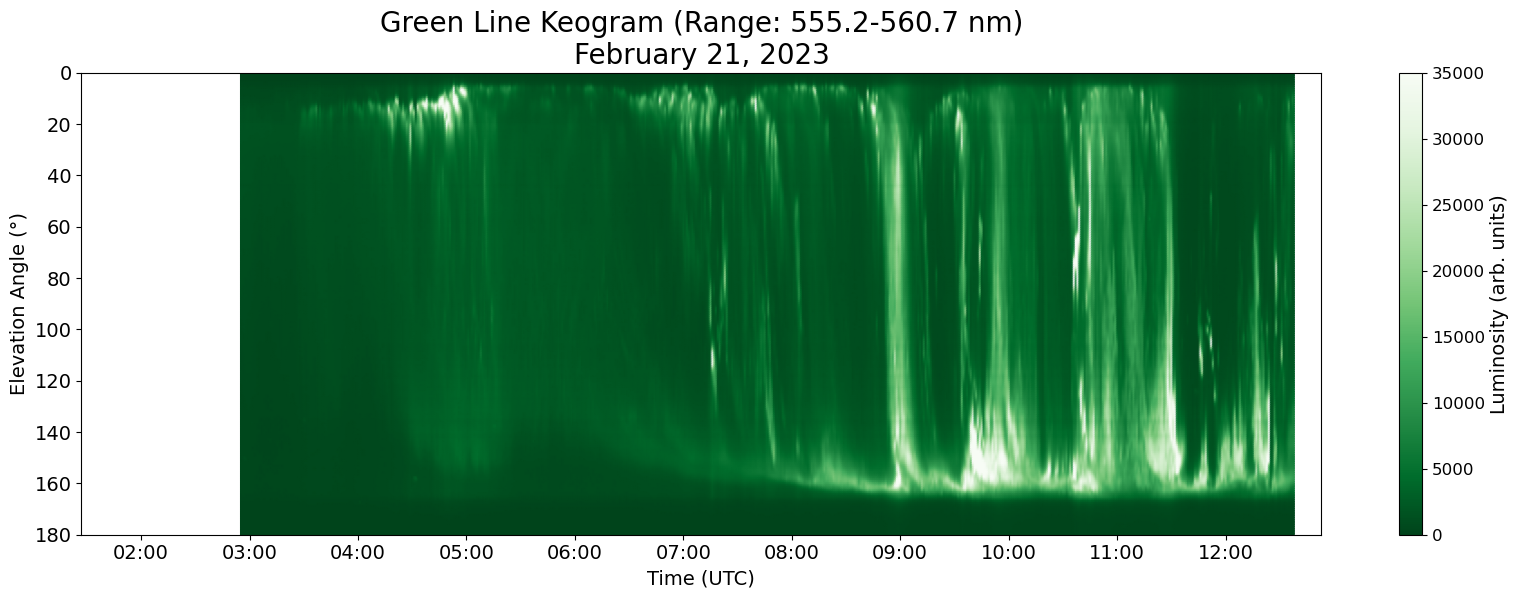

In [65]:
## GREEN KEOGRAM ##

plt.figure(figsize=(20, 6))
plt.pcolormesh(time_grid, elevation_angle_grid, green_line_keogram.T, vmin=0, vmax=35000, cmap='Greens_r', shading='gouraud')
plt.ylim((0, 180))

# adjust color bar labels
cbar = plt.colorbar(label='Luminosity (arb. units)')
cbar.ax.tick_params(labelsize=12)  # Adjust the font size of the color bar tick labels
cbar.set_label('Luminosity (arb. units)', fontsize=14)  # Adjust the font size of the color bar label

plt.xlabel('Time (UTC)', fontsize=14)
plt.ylabel('Elevation Angle (°)', fontsize=14)
plt.title(f'Green Line Keogram (Range: 555.2-560.7 nm)\n{formatted_date}', fontsize=20)
plt.gca().invert_yaxis()

# Format the x-tick labels to display only the time in the format "HH:MM"
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Adjust the size of the x-tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120'),
  Text(0, 140.0, '140'),
  Text(0, 160.0, '160'),
  Text(0, 180.0, '180')])

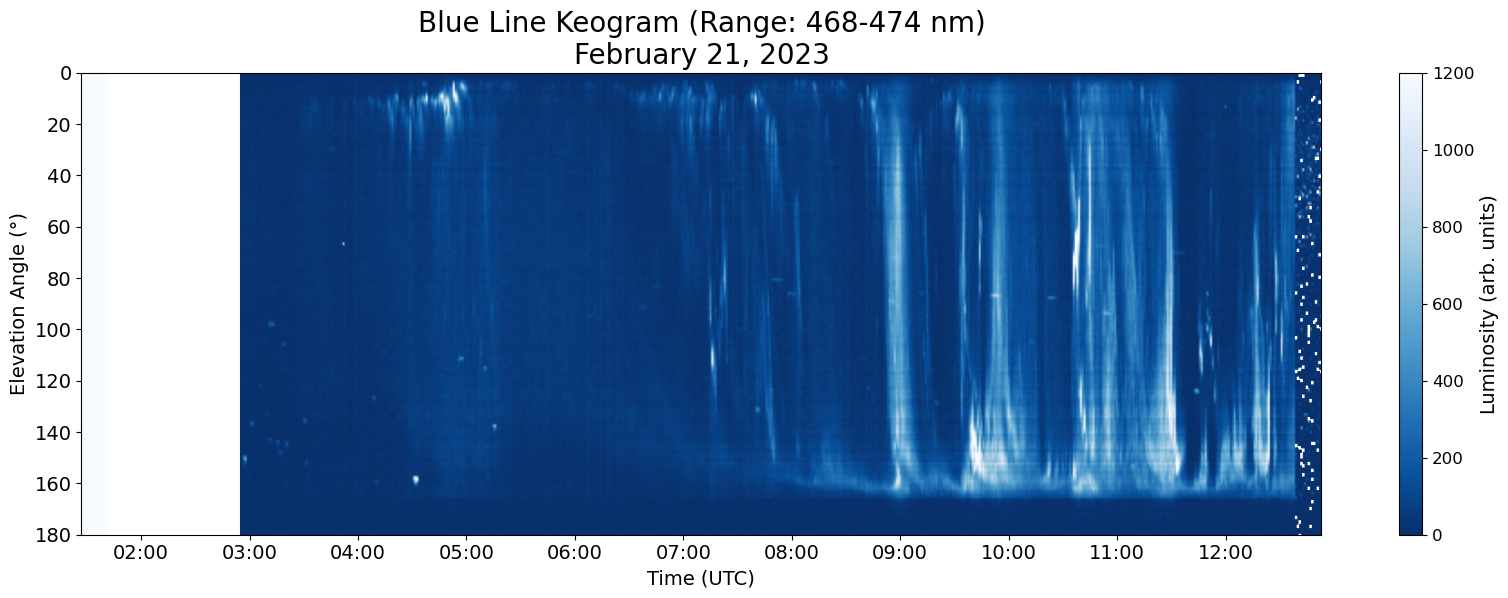

In [67]:
## BLUE KEOGRAM ##

plt.figure(figsize=(20, 6))
plt.pcolormesh(time_grid, elevation_angle_grid, blue_line_keogram.T, vmin=0, vmax=1200, cmap='Blues_r', shading='gouraud')
plt.ylim((0, 180))

# adjust color bar labels
cbar = plt.colorbar(label='Luminosity (arb. units)')
cbar.ax.tick_params(labelsize=12)  # Adjust the font size of the color bar tick labels
cbar.set_label('Luminosity (arb. units)', fontsize=14)  # Adjust the font size of the color bar label

plt.xlabel('Time (UTC)', fontsize=14)
plt.ylabel('Elevation Angle (°)', fontsize=14)
plt.title(f'Blue Line Keogram (Range: 468-474 nm)\n{formatted_date}', fontsize=20)
plt.gca().invert_yaxis()

# Format the x-tick labels to display only the time in the format "HH:MM"
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Adjust the size of the x-tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


/var/folders/k3/vs84nfp10mj73vn5vcy8dsg00000gn/T/ipykernel_32642/2922045057.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio_keogram = green_line_keogram / blue_line_keogram
/var/folders/k3/vs84nfp10mj73vn5vcy8dsg00000gn/T/ipykernel_32642/2922045057.py:3: RuntimeWarning: invalid value encountered in divide
  ratio_keogram = green_line_keogram / blue_line_keogram


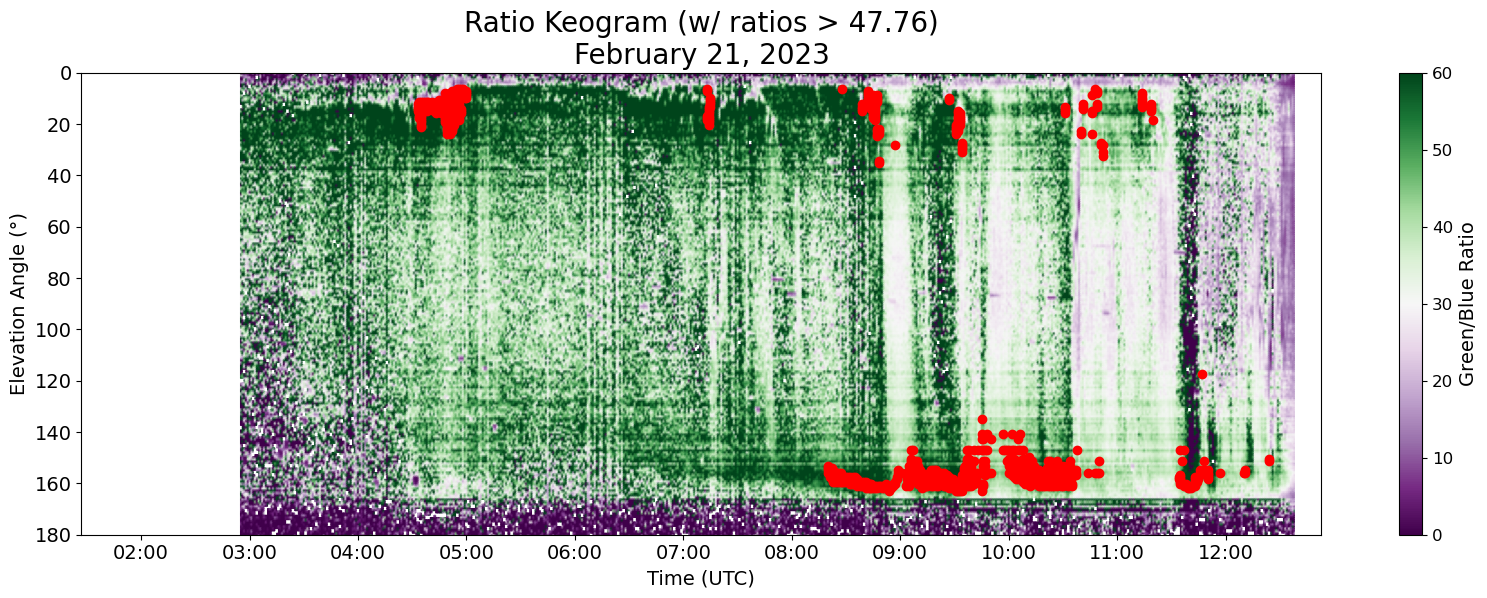

In [69]:
## RATIO KEOGRAM WITH OVERLAY ##

ratio_keogram = green_line_keogram / blue_line_keogram

plt.figure(figsize=(20, 6))
pcolormesh_plot = plt.pcolormesh(time_grid, elevation_angle_grid, ratio_keogram.T, vmin=0, vmax=60, cmap='PRGn', shading='gouraud')

if choose_day in persistent_high_ratio_indices:
    for t_idx, el_idx in persistent_high_ratio_indices[choose_day]:
        plt.scatter(filtered_time_array[t_idx], elevation_angle[el_idx], color='red')

plt.ylim((0, 180))

cbar = plt.colorbar(pcolormesh_plot, label='Green/Blue Ratio')


# adjust color bar labels
#cbar = plt.colorbar(label='Green/Blue Ratio')
cbar.ax.tick_params(labelsize=12)  # Adjust the font size of the color bar tick labels
cbar.set_label('Green/Blue Ratio', fontsize=14)  # Adjust the font size of the color bar label


plt.xlabel('Time (UTC)', fontsize=14)
plt.ylabel('Elevation Angle (°)', fontsize=14)
plt.title(f'Ratio Keogram (w/ ratios > {threshold_80th_percentile:.2f})\n{formatted_date}', fontsize=20)
plt.gca().invert_yaxis()

# Format the x-tick labels to display only the time in the format "HH:MM"
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('poster_fig_4_ratio', bbox_inches = 'tight')